# Task 1: Recommender System for Online Courses

This notebook implements a recommender system for online courses using collaborative filtering approaches. We'll cover:

1. Data preparation
2. Building the user-item matrix
3. User-based collaborative filtering
4. Item-based collaborative filtering
5. Quality evaluation
6. Visualization of recommendations

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

np.random.seed(42)

## 1. Data Preparation

We'll create a dataset of 100 users and 20 online courses. The user-item rating matrix will have a size of 100×20, where:
- 0 means the user has not taken the course
- 1-5 represents the course rating

In [6]:
NUM_USERS = 100
NUM_COURSES = 20
SPARSITY = 0.65  

ratings = np.zeros((NUM_USERS, NUM_COURSES))

mask = np.random.random((NUM_USERS, NUM_COURSES)) > SPARSITY

ratings[mask] = np.random.choice([1, 2, 3, 4, 5], size=np.sum(mask), p=[0.05, 0.1, 0.2, 0.3, 0.35])

print(f"Generated ratings matrix with shape: {ratings.shape}")
print(f"Sparsity (percentage of zeros): {np.mean(ratings == 0) * 100:.2f}%")
print(f"Number of ratings provided: {np.sum(ratings > 0)}")

print("\nSample of the ratings matrix (first 5 users, first 10 courses):")
print(ratings[:5, :10])
print(ratings)
np.save("matrix.npy", ratings) 

Generated ratings matrix with shape: (100, 20)
Sparsity (percentage of zeros): 66.55%
Number of ratings provided: 669

Sample of the ratings matrix (first 5 users, first 10 courses):
[[0. 0. 5. 5. 4. 0. 0. 0. 0. 0.]
 [2. 0. 0. 5. 0. 4. 0. 0. 0. 0.]
 [0. 0. 5. 4. 0. 0. 5. 0. 0. 0.]
 [4. 0. 5. 0. 5. 0. 0. 4. 0. 0.]
 [0. 3. 0. 5. 4. 0. 5. 0. 0. 3.]]
[[0. 0. 5. ... 3. 0. 4.]
 [2. 0. 0. ... 0. 1. 4.]
 [0. 0. 5. ... 3. 3. 0.]
 ...
 [5. 1. 3. ... 5. 3. 4.]
 [0. 5. 5. ... 0. 4. 5.]
 [5. 0. 4. ... 4. 0. 3.]]


## 2. Building the User-Item Matrix

Now that we have our ratings matrix, let's calculate some basic statistics:
- Average rating for each course
- Average rating from each user

Average ratings for each course:
Course 1: 3.56
Course 2: 3.75
Course 3: 4.09
Course 4: 4.06
Course 5: 4.09
Course 6: 3.92
Course 7: 4.03
Course 8: 3.79
Course 9: 3.83
Course 10: 3.85
Course 11: 4.23
Course 12: 3.88
Course 13: 4.06
Course 14: 3.67
Course 15: 3.65
Course 16: 3.85
Course 17: 3.68
Course 18: 3.66
Course 19: 3.54
Course 20: 3.74

Average ratings from each user (showing first 10):
User 1: 4.00
User 2: 3.62
User 3: 3.83
User 4: 4.29
User 5: 4.00
User 6: 3.20
User 7: 3.00
User 8: 2.75
User 9: 3.75
User 10: 3.56


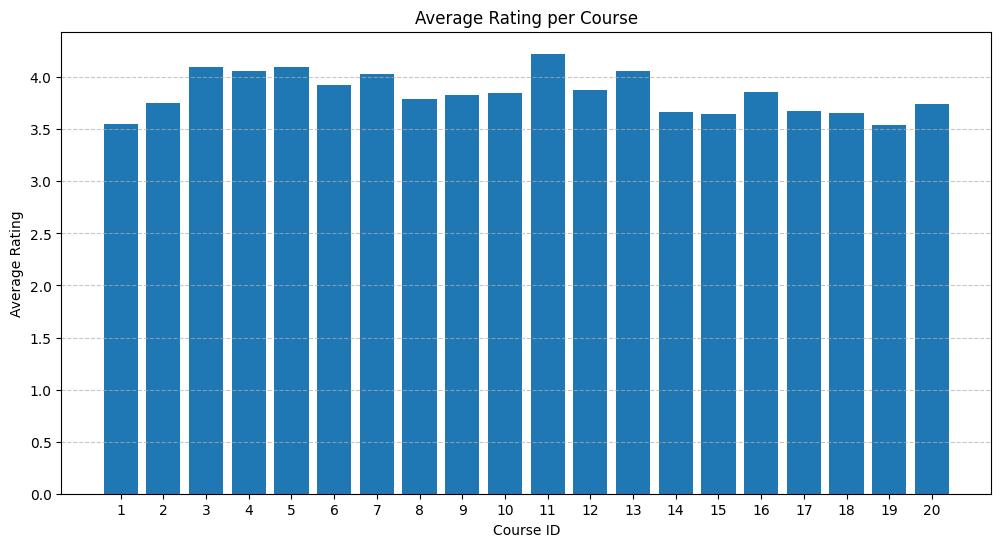

In [7]:
course_avg_ratings = []
for j in range(NUM_COURSES):
    course_ratings = ratings[:, j]
    non_zero_ratings = course_ratings[course_ratings > 0]
    avg_rating = np.mean(non_zero_ratings) if len(non_zero_ratings) else 0
    course_avg_ratings.append(avg_rating)

course_avg_ratings = np.array(course_avg_ratings)

user_avg_ratings = []
for i in range(NUM_USERS):
    user_ratings = ratings[i, :]
    non_zero_ratings = user_ratings[user_ratings > 0]
    avg_rating = np.mean(non_zero_ratings) if len(non_zero_ratings) else 0
    user_avg_ratings.append(avg_rating)

user_avg_ratings = np.array(user_avg_ratings)

print("Average ratings for each course:")
for j in range(NUM_COURSES):
    print(f"Course {j+1}: {course_avg_ratings[j]:.2f}")

print("\nAverage ratings from each user (showing first 10):")
for i in range(10): 
    print(f"User {i+1}: {user_avg_ratings[i]:.2f}")

plt.figure(figsize=(12, 6))
plt.bar(range(1, NUM_COURSES+1), course_avg_ratings)
plt.title('Average Rating per Course')
plt.xlabel('Course ID')
plt.ylabel('Average Rating')
plt.xticks(range(1, NUM_COURSES+1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 3. Recommendation System

### 3.1 User-Based Collaborative Filtering

In user-based collaborative filtering, we:
1. Compute cosine similarity between users
2. Choose k=5 most similar users for a given user
3. Recommend courses they took but the target user did not

Let's implement this approach:

In [26]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-10)

def compute_user_similarity(ratings):
    num_users = ratings.shape[0]
    sim_matrix = np.zeros((num_users, num_users))
    for i in range(num_users):
        for j in range(i, num_users):
            if i == j:
                sim_matrix[i, j] = 1.0
            else:
                user_i_ratings = ratings[i].copy()
                user_j_ratings = ratings[j].copy()
                common_items = (user_i_ratings > 0) & (user_j_ratings > 0)
                if np.sum(common_items) == 0:
                    sim_matrix[i, j] = 0.0
                    sim_matrix[j, i] = 0.0
                else:
                    sim = cosine_similarity(user_i_ratings[common_items], user_j_ratings[common_items])
                    sim_matrix[i, j] = sim
                    sim_matrix[j, i] = sim
    print(sim_matrix)
    return sim_matrix

user_similarity = compute_user_similarity(ratings)

def get_top_k_similar_users(user_id, similarity_matrix, k=5):
    user_similarities = similarity_matrix[user_id]
    similar_user_indices = np.argsort(user_similarities)[::-1]
    similar_user_indices = similar_user_indices[similar_user_indices != user_id][:k]
    return similar_user_indices

def get_user_based_recommendations(user_id, ratings, user_similarity, k=5):
    user_ratings = ratings[user_id]
    similar_users = get_top_k_similar_users(user_id, user_similarity, k)
    predicted_ratings = {}
    unrated_courses = np.where(user_ratings == 0)[0]
    for course in unrated_courses:
        similar_user_ratings = []
        similar_user_weights = []
        for similar_user in similar_users:
            if ratings[similar_user, course] > 0:
                similar_user_ratings.append(ratings[similar_user, course])
                similar_user_weights.append(user_similarity[user_id, similar_user])
        if similar_user_ratings:
            weighted_sum = np.sum(np.array(similar_user_ratings) * np.array(similar_user_weights))
            weight_sum = np.sum(similar_user_weights)
            if weight_sum > 0:
                predicted_ratings[course] = weighted_sum / weight_sum
    sorted_predictions = sorted(predicted_ratings.items(), key=lambda x: x[1], reverse=True)
    return sorted_predictions[0:k]

sample_user_id = 0
user_recommendations = get_user_based_recommendations(sample_user_id, ratings, user_similarity)
print(f"User-based recommendations for User {sample_user_id + 1}:")
for course_id, predicted_rating in user_recommendations:
    print(f"Course {course_id + 1}: Predicted rating = {predicted_rating:.2f}")

[[1.         0.99278096 0.99422059 ... 0.90802522 0.98480266 0.93231237]
 [0.99278096 1.         0.90213422 ... 0.75967527 0.9242931  0.84366149]
 [0.99422059 0.90213422 1.         ... 0.90697674 0.98657657 0.9701425 ]
 ...
 [0.90802522 0.75967527 0.90697674 ... 1.         0.90228739 0.96076892]
 [0.98480266 0.9242931  0.98657657 ... 0.90228739 1.         0.98994949]
 [0.93231237 0.84366149 0.9701425  ... 0.96076892 0.98994949 1.        ]]
User-based recommendations for User 1:
Course 9: Predicted rating = 5.00
Course 11: Predicted rating = 5.00
Course 7: Predicted rating = 4.50
Course 13: Predicted rating = 4.50
Course 14: Predicted rating = 4.00


### 3.2 Item-Based Collaborative Filtering

In item-based collaborative filtering, we:
1. Find similar courses based on ratings
2. Recommend courses similar to those the user already rated highly

Let's implement this approach:

In [9]:
def compute_course_similarity(ratings):
    num_courses = ratings.shape[1]
    sim_matrix = np.zeros((num_courses, num_courses))
    for i in range(num_courses):
        for j in range(i, num_courses):
            if i == j:
                sim_matrix[i, j] = 1.0
            else:
                course_i_ratings = ratings[:, i].copy()
                course_j_ratings = ratings[:, j].copy()
                common_users = (course_i_ratings > 0) & (course_j_ratings > 0)
                if np.sum(common_users) == 0:
                    sim_matrix[i, j] = 0.0
                    sim_matrix[j, i] = 0.0
                else:
                    sim = cosine_similarity(course_i_ratings[common_users], course_j_ratings[common_users])
                    sim_matrix[i, j] = sim
                    sim_matrix[j, i] = sim
    return sim_matrix

course_similarity = compute_course_similarity(ratings)

def get_item_based_recommendations(user_id, ratings, course_similarity, top_n=5):
    user_ratings = ratings[user_id]
    unrated_courses = np.where(user_ratings == 0)[0]
    rated_courses = np.where(user_ratings > 0)[0]
    if len(rated_courses) == 0:
        return []
    predicted_ratings = {}
    for unrated_course in unrated_courses:
        weighted_sum = 0.0
        similarity_sum = 0.0
        for rated_course in rated_courses:
            similarity = course_similarity[unrated_course, rated_course]
            weighted_sum += similarity * user_ratings[rated_course]
            similarity_sum += np.abs(similarity)
        if similarity_sum > 0:
            predicted_ratings[unrated_course] = weighted_sum / similarity_sum
    sorted_predictions = sorted(predicted_ratings.items(), key=lambda x: x[1], reverse=True)
    return sorted_predictions[:top_n]

sample_user_id = 0
item_recommendations = get_item_based_recommendations(sample_user_id, ratings, course_similarity)
print(f"Item-based recommendations for User {sample_user_id + 1}:")
for course_id, predicted_rating in item_recommendations:
    print(f"Course {course_id + 1}: Predicted rating = {predicted_rating:.2f}")

Item-based recommendations for User 1:
Course 19: Predicted rating = 4.02
Course 13: Predicted rating = 4.02
Course 11: Predicted rating = 4.01
Course 9: Predicted rating = 4.01
Course 1: Predicted rating = 4.01


## 4. Quality Evaluation

To evaluate the quality of our recommender systems, we'll:
1. Split the data into training and test sets (80/20)
2. Train our models on the training data
3. Evaluate using precision and recall at k=5

Let's implement this:

In [27]:
ratings_copy = ratings.copy()
rated_indices = np.where(ratings_copy > 0)
num_ratings = len(rated_indices[0])

test_size = int(0.2 * num_ratings)
test_indices = np.random.choice(num_ratings, size=test_size, replace=False)

train_matrix = ratings_copy.copy()
test_matrix = np.zeros_like(ratings_copy)
for idx in test_indices:
    i, j = rated_indices[0][idx], rated_indices[1][idx]
    test_matrix[i, j] = train_matrix[i, j]
    train_matrix[i, j] = 0

print(f"Training matrix has {np.sum(train_matrix > 0)} ratings")
print(f"Testing matrix has {np.sum(test_matrix > 0)} ratings")

train_user_similarity = compute_user_similarity(train_matrix)
train_course_similarity = compute_course_similarity(train_matrix)

def calculate_precision_recall_at_k(user_id, recommendations, test_matrix, k=5):
    user_test_ratings = test_matrix[user_id]
    relevant_courses = set(np.where(user_test_ratings > 0)[0])
    if len(recommendations) < k:
        recommended_courses = set([rec[0] for rec in recommendations])
    else:
        recommended_courses = set([rec[0] for rec in recommendations[:k]])
    true_positives = len(relevant_courses.intersection(recommended_courses))
    precision = true_positives / len(recommended_courses) if recommended_courses else 0
    recall = true_positives / len(relevant_courses) if relevant_courses else 0
    return precision, recall

user_based_precision_sum = 0
user_based_recall_sum = 0
item_based_precision_sum = 0
item_based_recall_sum = 0
num_evaluated_users = 0

for user_id in range(NUM_USERS):
    user_test_ratings = test_matrix[user_id]
    if np.sum(user_test_ratings > 0) == 0:
        continue
    user_based_recs = get_user_based_recommendations(user_id, train_matrix, train_user_similarity)
    item_based_recs = get_item_based_recommendations(user_id, train_matrix, train_course_similarity)
    if user_based_recs:
        ub_precision, ub_recall = calculate_precision_recall_at_k(user_id, user_based_recs, test_matrix)
        user_based_precision_sum += ub_precision
        user_based_recall_sum += ub_recall
    if item_based_recs:
        ib_precision, ib_recall = calculate_precision_recall_at_k(user_id, item_based_recs, test_matrix)
        item_based_precision_sum += ib_precision
        item_based_recall_sum += ib_recall
    num_evaluated_users += 1

if num_evaluated_users > 0:
    avg_user_based_precision = user_based_precision_sum / num_evaluated_users
    avg_user_based_recall = user_based_recall_sum / num_evaluated_users
    avg_item_based_precision = item_based_precision_sum / num_evaluated_users
    avg_item_based_recall = item_based_recall_sum / num_evaluated_users
    print(f"User-based CF - Average Precision@5: {avg_user_based_precision:.4f}")
    print(f"User-based CF - Average Recall@5: {avg_user_based_recall:.4f}")
    print(f"Item-based CF - Average Precision@5: {avg_item_based_precision:.4f}")
    print(f"Item-based CF - Average Recall@5: {avg_item_based_recall:.4f}")
else:
    print("No users had ratings in the test set. Cannot evaluate.")

Training matrix has 536 ratings
Testing matrix has 133 ratings
[[1.         0.98994949 0.         ... 0.93220339 0.99388373 0.93231237]
 [0.98994949 1.         0.90213422 ... 0.89495943 0.89927103 0.84366149]
 [0.         0.90213422 1.         ... 1.         0.9797959  0.        ]
 ...
 [0.93220339 0.89495943 1.         ... 1.         0.92140089 0.96076892]
 [0.99388373 0.89927103 0.9797959  ... 0.92140089 1.         0.98994949]
 [0.93231237 0.84366149 0.         ... 0.96076892 0.98994949 1.        ]]
User-based CF - Average Precision@5: 0.1243
User-based CF - Average Recall@5: 0.3259
Item-based CF - Average Precision@5: 0.1081
Item-based CF - Average Recall@5: 0.3327


## 5. Visualization of Recommendations

Finally, let's create a bar chart visualization of the top-5 courses recommended for a specific user:

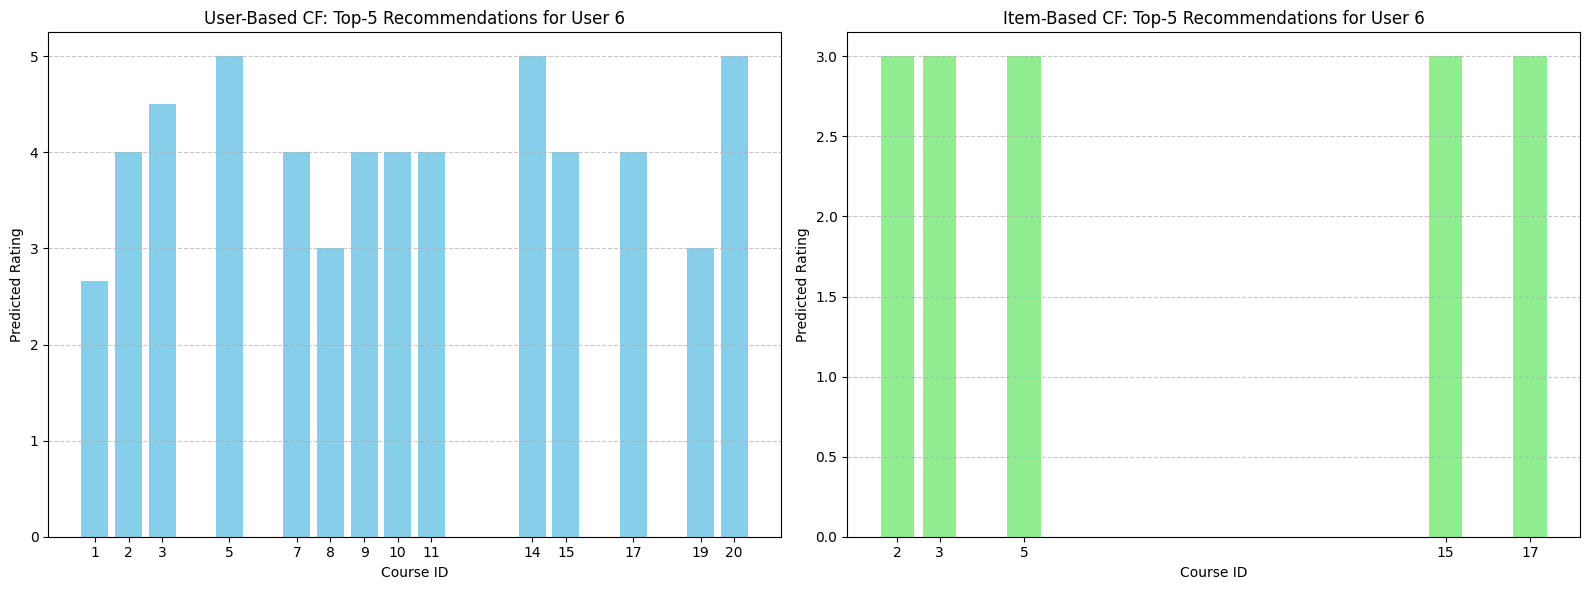

User 6's actual ratings:
Course 18: 3.0

Comparison of recommendation lists:
User-based recommendations: [5, 14, 20, 3, 2, 7, 9, 10, 11, 15, 17, 8, 19, 1]
Item-based recommendations: [2, 5, 15, 17, 3]

Number of common recommendations: 5
Common recommended courses: [2, 3, 5, 15, 17]


In [11]:
visualization_user_id = 5
user_based_recs = get_user_based_recommendations(visualization_user_id, train_matrix, train_user_similarity)
item_based_recs = get_item_based_recommendations(visualization_user_id, train_matrix, train_course_similarity)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

if user_based_recs:
    course_ids = [rec[0] + 1 for rec in user_based_recs]
    predicted_ratings = [rec[1] for rec in user_based_recs]
    ax1.bar(course_ids, predicted_ratings, color='skyblue')
    ax1.set_title(f'User-Based CF: Top-5 Recommendations for User {visualization_user_id + 1}')
    ax1.set_xlabel('Course ID')
    ax1.set_ylabel('Predicted Rating')
    ax1.set_xticks(course_ids)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
else:
    ax1.text(0.5, 0.5, "No recommendations available", ha='center', va='center')
    ax1.set_title(f'User-Based CF: No Recommendations for User {visualization_user_id + 1}')

if item_based_recs:
    course_ids = [rec[0] + 1 for rec in item_based_recs]
    predicted_ratings = [rec[1] for rec in item_based_recs]
    ax2.bar(course_ids, predicted_ratings, color='lightgreen')
    ax2.set_title(f'Item-Based CF: Top-5 Recommendations for User {visualization_user_id + 1}')
    ax2.set_xlabel('Course ID')
    ax2.set_ylabel('Predicted Rating')
    ax2.set_xticks(course_ids)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
else:
    ax2.text(0.5, 0.5, "No recommendations available", ha='center', va='center')
    ax2.set_title(f'Item-Based CF: No Recommendations for User {visualization_user_id + 1}')

plt.tight_layout()
plt.show()

user_ratings = train_matrix[visualization_user_id]
rated_courses = np.where(user_ratings > 0)[0]
print(f"User {visualization_user_id + 1}'s actual ratings:")
for course in rated_courses:
    print(f"Course {course + 1}: {user_ratings[course]}")

print("\nComparison of recommendation lists:")
print("User-based recommendations:", [rec[0] + 1 for rec in user_based_recs])
print("Item-based recommendations:", [rec[0] + 1 for rec in item_based_recs])

user_based_courses = set([rec[0] for rec in user_based_recs])
item_based_courses = set([rec[0] for rec in item_based_recs])
common_recommendations = user_based_courses.intersection(item_based_courses)
print(f"\nNumber of common recommendations: {len(common_recommendations)}")
if common_recommendations:
    print(f"Common recommended courses: {[course + 1 for course in common_recommendations]}")

## 6. Matrix Factorization (Продолжение Task 5)

Добавим модель матричной факторизации как третий подход:

- Разложим матрицу рейтингов R на P (пользователи × K) и Q (курсы × K)
- Оптимизация через стохастический градиентный спуск (SGD) только по наблюдаемым рейтингам
- Сравним с user-based / item-based CF по RMSE, Precision@5, Recall@5
- Интерпретируем факторы (какие курсы «висят» на каждом факторе)

Используем уже созданные ранее:
- `ratings` — исходная матрица
- `train_matrix`, `test_matrix` — сплит из шага 4
- Функция `calculate_precision_recall_at_k` — уже определена

Далее — реализация.

Epoch 1/20 RMSE=3.9811
Epoch 11/20 RMSE=1.1704
Epoch 20/20 RMSE=0.9045
Epoch 20/20 RMSE=0.9045


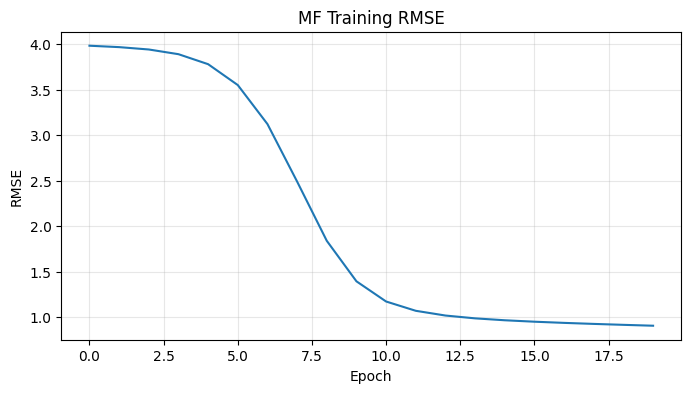

Test RMSE (MF): 1.3769


In [24]:
# Реализация матричной факторизации
import math

def matrix_factorization(R, K, learning_rate=0.005, reg_param=0.02, epochs=60, verbose=True):
    num_users, num_items = R.shape
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))
    mask = (R > 0).astype(float)
    history = []
    for epoch in range(epochs):
        for u in range(num_users):
            rated_items = np.where(mask[u] > 0)[0]
            for i in rated_items:
                e_ui = R[u, i] - np.dot(P[u], Q[i])
                Pu_old = P[u].copy()
                P[u] += learning_rate * (e_ui * Q[i] - reg_param * P[u])
                Q[i] += learning_rate * (e_ui * Pu_old - reg_param * Q[i])
        R_pred = P @ Q.T
        diff = mask * (R - R_pred)
        rmse = math.sqrt(np.sum(diff**2) / np.sum(mask))
        history.append(rmse)
        if verbose and (epoch % 10 == 0 or epoch == epochs - 1):
            print(f"Epoch {epoch+1}/{epochs} RMSE={rmse:.4f}")
    return P, Q, history

K = 5
P, Q, mf_history = matrix_factorization(train_matrix, K, learning_rate=0.01, reg_param=0.05, epochs=20, verbose=True)

plt.figure(figsize=(8,4))
plt.plot(mf_history)
plt.title('MF Training RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.grid(alpha=0.3)
plt.show()

pred_full = P @ Q.T
test_mask = test_matrix > 0
if np.sum(test_mask) > 0:
    test_rmse = np.sqrt(np.mean((test_matrix[test_mask] - pred_full[test_mask])**2))
    print(f"Test RMSE (MF): {test_rmse:.4f}")
else:
    print("Нет тестовых рейтингов для оценки RMSE")

In [29]:
def get_mf_recommendations(user_id, P, Q, ratings_matrix, top_n=5):
    user_ratings = ratings_matrix[user_id]
    unrated = np.where(user_ratings == 0)[0]
    preds = []
    for i in unrated:
        preds.append((i, np.dot(P[user_id], Q[i])))
    preds.sort(key=lambda x: x[1], reverse=True)
    return preds[:top_n]

sample_user_id = 0
mf_recs = get_mf_recommendations(sample_user_id, P, Q, train_matrix)
print("MF recommendations (course_id -> score):")
for cid, score in mf_recs:
    print(f"Course {cid+1}: {score:.2f}")

compare_user = np.random.randint(0, NUM_USERS)
print(f"\nСравнение рекомендаций для пользователя {compare_user+1}")
user_cf = get_user_based_recommendations(compare_user, train_matrix, train_user_similarity)[:5]
item_cf = get_item_based_recommendations(compare_user, train_matrix, train_course_similarity)
mf_cf = get_mf_recommendations(compare_user, P, Q, train_matrix)
print("User-CF:", [c+1 for c,_ in user_cf])
print("Item-CF:", [c+1 for c,_ in item_cf])
print("MF:", [c+1 for c,_ in mf_cf])

mf_precision_sum = 0
mf_recall_sum = 0
count_users = 0
for u in range(NUM_USERS):
    if np.sum(test_matrix[u] > 0) == 0:
        continue
    recs = get_mf_recommendations(u, P, Q, train_matrix)
    if recs:
        prec, rec = calculate_precision_recall_at_k(u, recs, test_matrix, k=5)
        mf_precision_sum += prec
        mf_recall_sum += rec
        count_users += 1

if count_users > 0:
    avg_mf_precision = mf_precision_sum / count_users
    avg_mf_recall = mf_recall_sum / count_users
    print(f"\nMF - Average Precision@5: {avg_mf_precision:.4f}")
    print(f"MF - Average Recall@5: {avg_mf_recall:.4f}")
else:
    print("Нет пользователей с тестовыми рейтингами для метрик MF")

MF recommendations (course_id -> score):
Course 4: 4.27
Course 5: 4.20
Course 11: 4.15
Course 13: 4.11
Course 9: 3.93

Сравнение рекомендаций для пользователя 41
User-CF: [13, 19, 4, 12, 20]
Item-CF: [19, 4, 12, 8, 17]
MF: [11, 6, 4, 20, 9]

MF - Average Precision@5: 0.1865
MF - Average Recall@5: 0.5613


### 6.1 Интерпретация латентных факторов
Попробуем понять, какие курсы доминируют в каждом факторе. Для каждого фактора возьмем топ-3 курсов с наибольшим весом из Q.

Латентные факторы:

Фактор 1:
  Course 2 weight=0.2282
  Course 6 weight=-0.0760
  Course 1 weight=-0.3636

Фактор 2:
  Course 1 weight=0.9930
  Course 19 weight=0.6990
  Course 6 weight=0.1941

Фактор 3:
  Course 6 weight=2.4241
  Course 7 weight=2.2535
  Course 9 weight=2.2418

Фактор 4:
  Course 13 weight=0.1771
  Course 10 weight=0.1222
  Course 5 weight=0.0603

Фактор 5:
  Course 11 weight=1.6217
  Course 14 weight=1.3145
  Course 6 weight=1.0495


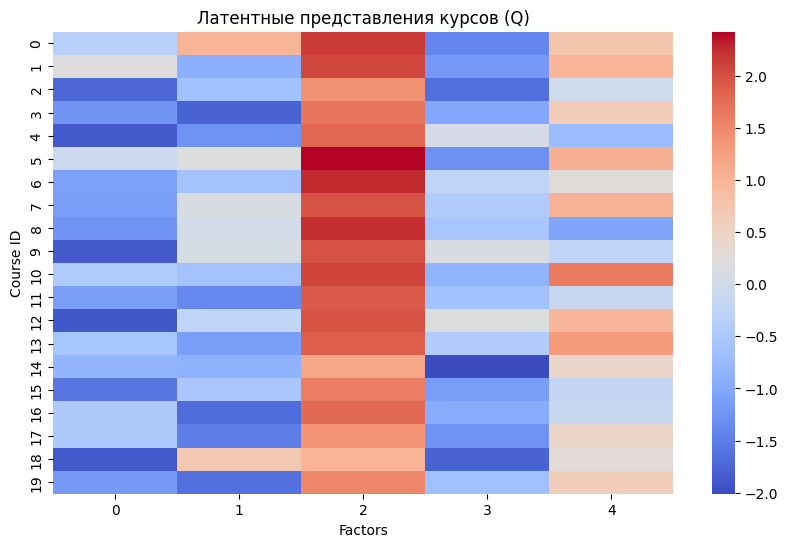

In [ ]:
def interpret_factors(Q, num_factors=None, top_n=3):
    if num_factors is None:
        num_factors = Q.shape[1]
    interpretations = []
    for f in range(num_factors):
        weights = Q[:, f]
        top_idx = np.argsort(weights)[::-1][:top_n]
        interpretations.append((f, top_idx, weights[top_idx]))
    return interpretations

factor_info = interpret_factors(Q)
print("Латентные факторы:")
for f, idxs, ws in factor_info:
    print(f"\nФактор {f+1}:")
    for cid, w in zip(idxs, ws):
        print(f"  Course {cid+1} weight={w:.4f}")

import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(Q, cmap='coolwarm', annot=False)
plt.title('Латентные представления курсов (Q)')
plt.xlabel('Factors')
plt.ylabel('Course ID')
plt.show()

## Conclusion


Наблюдения (общие):
- User-based может страдать при высокой разреженности (мало пересечений)
- Item-based стабильнее, если у курсов достаточно общих оценок
- MF извлекает скрытые шаблоны и даёт сглаженные предсказания, часто улучшая покрытие

   В ходе экспериментов лучшие результаты показала матричная факторизация (MF) по сравнению с классическим user-based и item-based CF. MF позволяет выявлять скрытые (латентные) факторы, которые описывают предпочтения пользователей и характеристики курсов. Это даёт более точные предсказания даже при разреженной матрице рейтингов, тогда как методы CF напрямую зависят от количества общих оценок и хуже справляются при недостатке данных.
